In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,OrdinalEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.feature_selection import RFE,SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from helpers import pre_rec_curve,roc_auc,evaluate_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB

In [2]:
seq = pd.read_csv('dataset/pdb_data_seq.csv')

seq.head(10)

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
5,102D,A,CGCAAATTTGCG,24,DNA
6,102D,B,CGCAAATTTGCG,24,DNA
7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
9,103D,A,GTGGAATGGAAC,24,DNA


In [3]:
seq.describe()

,residueCount
count,467304.000000
mean,6173.426620
std,23645.559738
min,0.000000
25%,456.000000
50%,1131.000000
75%,4342.000000
max,313236.000000


In [4]:
structure = pd.read_csv('dataset/pdb_data_no_dups.csv')
structure.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [276]:
structure.describe()

,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear
count,141401.000000,128589.000000,1.414010e+05,97039.000000,124724.000000,124749.000000,105110.000000,117602.000000
mean,825.374849,2.263807,1.120790e+05,290.967713,2.670267,51.353163,6.788685,2008.922365
std,2136.461080,1.410878,5.690152e+05,9.541080,0.783740,10.104561,2.556819,8.459286
min,0.000000,0.480000,3.143800e+02,4.000000,0.000000,0.000000,0.000000,201.000000
25%,226.000000,1.800000,2.612856e+04,290.000000,2.210000,44.370000,6.000000,2005.000000
50%,414.000000,2.100000,4.747779e+04,293.000000,2.490000,50.500000,7.000000,2010.000000
75%,820.000000,2.500000,9.408484e+04,295.000000,2.910000,57.710000,7.500000,2014.000000
max,313236.000000,70.000000,9.773054e+07,398.000000,99.000000,92.000000,724.000000,2018.000000


In [5]:
df = seq.set_index('structureId').merge(structure.set_index('structureId'),on='structureId',how='left')
df = df.reset_index()
df.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
2,101D,A,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
3,101D,B,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
residueCount_x,471149.0,6257.931820,2.361838e+04,0.00,456.00,1140.00,4528.00,313236.0
residueCount_y,471149.0,6257.931820,2.361838e+04,0.00,456.00,1140.00,4528.00,313236.0
resolution,449486.0,3.020658,3.091223e+00,0.48,2.00,2.50,3.10,70.0
structureMolecularWeight,471149.0,926115.287672,3.018842e+06,453.55,52766.84,131138.55,635323.06,97730536.0
crystallizationTempK,317697.0,290.889746,8.785254e+00,4.00,291.00,293.00,295.00,398.0
densityMatthews,389645.0,2.850779,8.243937e-01,0.00,2.32,2.67,3.19,99.0
densityPercentSol,389768.0,54.198949,1.026988e+01,0.00,46.89,53.95,61.37,92.0
phValue,340694.0,6.830608,2.461778e+00,0.00,6.10,7.00,7.50,724.0
publicationYear,413513.0,2010.483702,6.997897e+00,201.00,2007.00,2012.00,2015.00,2018.0


In [7]:
df.dropna(inplace=True)
df.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
5,102D,A,CGCAAATTTGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
6,102D,B,CGCAAATTTGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
45,110D,A,CGGCCG,6,DNA,DNA,X-RAY DIFFRACTION,DNA,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.0,2.90,57.63,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1993.0
48,111D,A,CGCAAATTGGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1989.0
49,111D,B,CGCAAATTGGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1989.0


#### encoding nominal data

In [8]:
df['sequence']= df['sequence'].astype(str).apply(lambda x : ' '.join(x))
new_df = df.loc[:, [col for col in df.columns if col not in  ['chainId','structureId']]]
seq_vec = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
tst = seq_vec.fit_transform(df['sequence'])


In [9]:
# col_vec = ColumnTransformer([('count',CountVectorizer(),'sequence'),('nums',StandardScaler(),numeric_features),('cats',OrdinalEncoder(),categorical_features)])
# df['sequence']= [row for row in tst]
# encoded_data = col_vec.fit_transform(df)
# encoded_data

seq_chars = pd.DataFrame(tst.todense(),columns=seq_vec.get_feature_names(),index=new_df.index)
seq_chars.nunique()

a    188
b      3
c    110
d    117
e    135
f     89
g    173
h     55
i    129
k    133
l    179
m     54
n    120
o      2
p     97
q     94
r    109
s    136
t    114
u     97
v    132
w     42
x    125
y     84
z      3
dtype: int64

In [10]:
columns = ['sequence','residueCount_x','macromoleculeType_x','residueCount_y','densityPercentSol','macromoleculeType_y','structureMolecularWeight','experimentalTechnique','resolution','crystallizationMethod','crystallizationTempK','densityMatthews','pdbxDetails','phValue','publicationYear']

numeric_features = ['residueCount_x','residueCount_y','resolution','structureMolecularWeight','crystallizationTempK','densityMatthews','densityPercentSol',
                   'phValue','publicationYear']
numeric_transformer = StandardScaler()

categorical_features = ['macromoleculeType_x','experimentalTechnique','macromoleculeType_y','crystallizationMethod','pdbxDetails']
                       
categorical_transformer = OrdinalEncoder()


In [11]:
seq_chars = seq_chars.drop(['b','o','z'],axis=1)
seq_chars.head()

,a,c,d,e,f,g,h,i,k,l,...,p,q,r,s,t,u,v,w,x,y
5,3,3,0,0,0,3,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
6,3,3,0,0,0,3,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
45,0,3,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,3,3,0,0,0,4,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
49,3,3,0,0,0,4,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [12]:
new_df[seq_chars.columns] = seq_chars
new_df = new_df.drop('sequence',axis=1)
new_df.head()

,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,...,p,q,r,s,t,u,v,w,x,y
5,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,3,0,0,0,0,0
6,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,3,0,0,0,0,0
45,6,DNA,DNA,X-RAY DIFFRACTION,DNA,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,0,0,0,0,0,0
48,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,2,0,0,0,0,0
49,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,2,0,0,0,0,0


In [13]:
transformed_numeric = numeric_transformer.fit_transform(new_df[numeric_features])
transformed_categ = categorical_transformer.fit_transform(new_df[categorical_features])
transformed_seq = numeric_transformer.fit_transform(new_df[seq_chars.columns])

In [14]:
new_df[numeric_features] = transformed_numeric
new_df[categorical_features] = transformed_categ
new_df[seq_chars.columns] = transformed_seq
X = new_df.drop('classification',axis=1)  
y = new_df.classification


In [15]:
new_df.describe().T

,count,mean,std,min,25%,50%,75%,max
residueCount_x,215142.0,-2.522467e-14,1.000002,-0.483345,-0.430975,-0.369471,-0.144961,9.823691
macromoleculeType_x,215142.0,4.738824e+00,1.787322,0.000000,4.000000,4.000000,4.000000,12.000000
experimentalTechnique,215142.0,5.999391e+00,0.054239,0.000000,6.000000,6.000000,6.000000,8.000000
macromoleculeType_y,215142.0,4.738824e+00,1.787322,0.000000,4.000000,4.000000,4.000000,12.000000
residueCount_y,215142.0,-2.522467e-14,1.000002,-0.483345,-0.430975,-0.369471,-0.144961,9.823691
resolution,215142.0,9.746822e-15,1.000002,-2.686965,-0.699109,-0.090582,0.585559,9.510626
structureMolecularWeight,215142.0,3.410125e-15,1.000002,-0.442822,-0.408799,-0.369411,-0.224608,7.635687
crystallizationMethod,215142.0,1.824071e+02,31.398226,0.000000,183.000000,183.000000,197.000000,405.000000
crystallizationTempK,215142.0,5.623498e-16,1.000002,-33.182106,0.004772,0.236040,0.467307,12.377581
densityMatthews,215142.0,-1.946180e-15,1.000002,-3.784181,-0.710578,-0.222495,0.489842,12.968935


### EDA

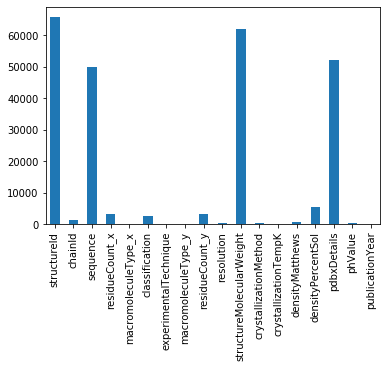

In [16]:
df.nunique().plot(kind='bar')

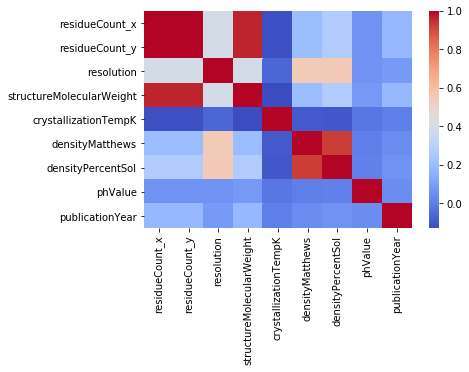

In [17]:
sns.heatmap(df.corr(),cmap='coolwarm')

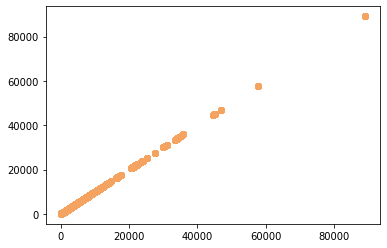

In [18]:
plt.scatter(x=df['residueCount_x'],y=df['residueCount_y'],color='sandybrown',alpha=0.8)

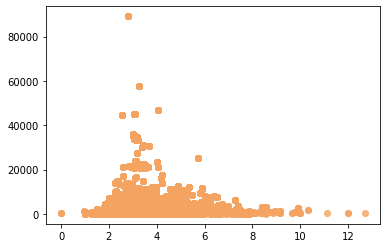

In [19]:
plt.scatter(x=df['densityMatthews'],y=df['residueCount_y'],color='sandybrown',alpha=0.8)

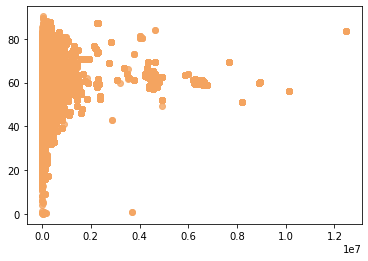

In [20]:
plt.scatter(x=df['structureMolecularWeight'],y=df['densityPercentSol'],color='sandybrown',alpha=0.8)

#### removing correlated features

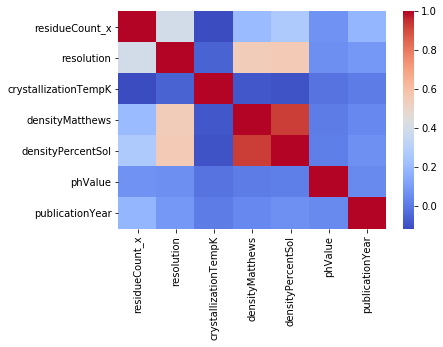

In [21]:

df = df.drop(['residueCount_y','structureMolecularWeight','macromoleculeType_y','pdbxDetails'],axis=1)

sns.heatmap(df.corr(),cmap='coolwarm')

In [22]:
new_df = new_df.drop(['residueCount_y','structureMolecularWeight','macromoleculeType_y','pdbxDetails'],axis=1)


#### classifiers

In [23]:
new_df['classification'].value_counts()

HYDROLASE                                  23115
RIBOSOME                                   19120
TRANSFERASE                                18270
OXIDOREDUCTASE                             17037
IMMUNE SYSTEM                               9712
HYDROLASE/HYDROLASE INHIBITOR               8966
LYASE                                       6224
TRANSCRIPTION                               4941
TRANSPORT PROTEIN                           4067
VIRAL PROTEIN                               4018
ISOMERASE                                   3206
SIGNALING PROTEIN                           3131
LIGASE                                      2960
PROTEIN BINDING                             2784
TRANSFERASE/TRANSFERASE INHIBITOR           2277
MEMBRANE PROTEIN                            2186
SUGAR BINDING PROTEIN                       2126
TRANSFERASE/DNA                             1983
DNA BINDING PROTEIN                         1888
STRUCTURAL PROTEIN                          1693
CHAPERONE           

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

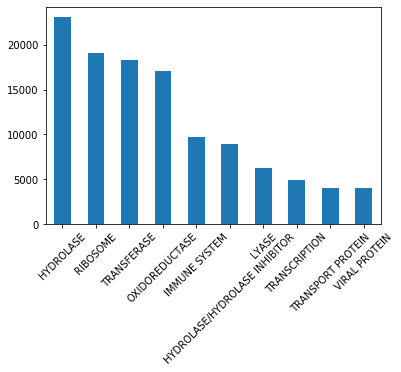

In [24]:
# getting top 10 classes
new_df['classification'].value_counts()[:10].plot(kind='bar')
plt.xticks(rotation=45)

### selecting top frequent classes

In [25]:
counts = new_df.classification.value_counts()
data = np.asarray(counts[(counts > 11000)].index)

In [26]:
data = new_df[new_df.classification.isin(data)]
data.head()

,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,resolution,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,...,p,q,r,s,t,u,v,w,x,y
916,-0.440686,4.0,OXIDOREDUCTASE,6.0,0.179875,183.0,-1.6141,-0.750152,-0.773584,1.231901,...,0.859013,-0.112606,-0.054288,0.827637,0.937911,-0.063242,1.537017,-0.042147,-0.014862,-0.537077
2188,-0.437449,4.0,OXIDOREDUCTASE,6.0,-0.766723,321.0,-1.6141,-1.079938,-2.244163,-0.565332,...,-0.198891,-0.350688,-0.676519,-0.376909,-0.649386,-0.063242,-0.412778,0.968337,-0.014862,0.098645
2189,-0.437449,4.0,OXIDOREDUCTASE,6.0,-0.766723,321.0,-1.6141,-1.079938,-2.244163,-0.565332,...,-0.198891,-0.350688,-0.676519,-0.376909,-0.649386,-0.063242,-0.412778,0.968337,-0.014862,0.098645
2190,-0.437449,4.0,OXIDOREDUCTASE,6.0,-1.172408,321.0,-1.6141,-1.093129,-2.224317,-0.526262,...,-0.198891,-0.350688,-0.676519,-0.376909,-0.649386,-0.063242,-0.412778,0.968337,-0.014862,0.098645
2191,-0.437449,4.0,OXIDOREDUCTASE,6.0,-1.172408,321.0,-1.6141,-1.093129,-2.224317,-0.526262,...,-0.198891,-0.350688,-0.676519,-0.376909,-0.649386,-0.063242,-0.412778,0.968337,-0.014862,0.098645


In [315]:
data.classification.value_counts()

HYDROLASE         23115
RIBOSOME          19120
TRANSFERASE       18270
OXIDOREDUCTASE    17037
Name: classification, dtype: int64

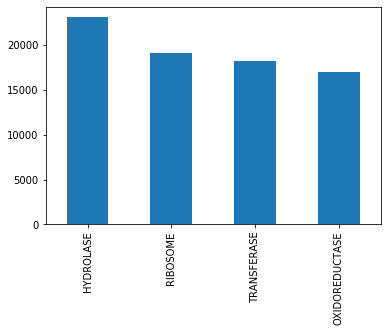

In [27]:
data.classification.value_counts().plot(kind='bar')


In [28]:
X = data.drop('classification',axis=1) 
y = data.classification
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

### Baseline Model

In [29]:
mn = GaussianNB()

Training Score:0.5166993539455469
Testing Score: 0.4896832765913546
precision Score: 0.6114534655391222
recall Score: 0.4896832765913546
Cross V Score: [0.52230154 0.51559593 0.51704595]
Cross & Test Diff: 0.02863119519386681
Standard Deviations Away: 9.93877383


,f1-score,precision,recall,support
HYDROLASE,0.143054,0.622667,0.080810,5779.000000
OXIDOREDUCTASE,0.462934,0.303948,0.970650,4259.000000
RIBOSOME,0.997907,0.998534,0.997280,4780.000000
TRANSFERASE,0.051771,0.478927,0.027364,4568.000000
accuracy,0.489683,0.489683,0.489683,0.489683
macro avg,0.413916,0.601019,0.519026,19386.000000
weighted avg,0.402601,0.611453,0.489683,19386.000000


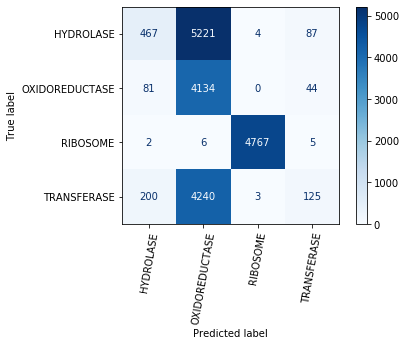

In [32]:
evaluate_model(X_train_smot,y_train_smote,X_test,y_test,mn)

#### knn 

In [33]:
knn = KNeighborsClassifier()


In [ ]:
evaluate_model(X_train,y_train,X_test,y_test,knn)

### Solving low variate classes

In [31]:
smote = SMOTE()
X_train_smot,y_train_smote = smote.fit_resample(X_train,y_train)


In [321]:
X_train_smot.shape

(69344, 32)

In [322]:
y_train_smote.value_counts()


OXIDOREDUCTASE    17336
RIBOSOME          17336
HYDROLASE         17336
TRANSFERASE       17336
Name: classification, dtype: int64

Training Score:0.9619577757268113
Testing Score: 0.9174662127308367
precision Score: 0.9179959228946504
recall Score: 0.9174662127308367
Cross V Score: [0.90019468 0.90149254 0.92571602]
Cross & Test Diff: -0.008331801943955552
Standard Deviations Away: -0.7098790673637736


,precision,recall,f1-score,support
HYDROLASE,0.913887,0.872296,0.892607,5779.000000
OXIDOREDUCTASE,0.878175,0.917351,0.897336,4259.000000
RIBOSOME,0.999791,0.998745,0.999267,4780.000000
TRANSFERASE,0.874731,0.889667,0.882136,4568.000000
accuracy,0.917466,0.917466,0.917466,0.917466
macro avg,0.916646,0.919515,0.917837,19386.000000
weighted avg,0.917996,0.917466,0.917478,19386.000000


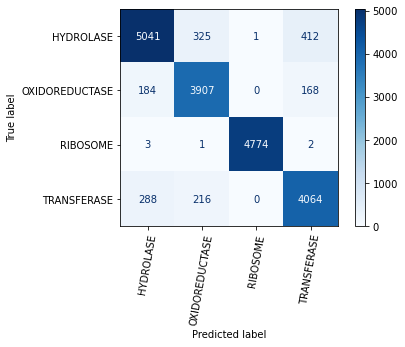

In [323]:
evaluate_model(X_train_smot,y_train_smote,X_test,y_test,knn)

#### RandomForest

Training Score:0.9999656097393218
Testing Score: 0.9486227174249459
precision Score: 0.9495365426086987
recall Score: 0.9486227174249459
Cross V Score: [0.91669246 0.92396183 0.91338664]
Cross & Test Diff: -0.030609076163807147
Standard Deviations Away: -6.929484080023446


,precision,recall,f1-score,support
HYDROLASE,0.907398,0.952933,0.929608,5779.000000
OXIDOREDUCTASE,0.974813,0.917821,0.945459,4259.000000
RIBOSOME,1.000000,0.999582,0.999791,4780.000000
TRANSFERASE,0.926474,0.918564,0.922502,4568.000000
accuracy,0.948623,0.948623,0.948623,0.948623
macro avg,0.952171,0.947225,0.949340,19386.000000
weighted avg,0.949537,0.948623,0.948721,19386.000000


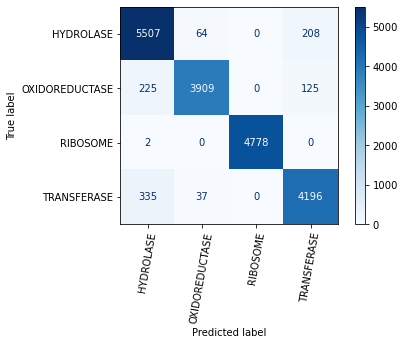

In [106]:

rf = RandomForestClassifier(n_estimators=60, random_state=42)
evaluate_model(X_train,y_train,X_test,y_test,rf)

### Random Forest model selcetion 

In [325]:
params= {
    'n_estimators': [175,200,225],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(param_grid=params,estimator=rf,cv=5)

In [326]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=60, random_state=42),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [175, 200, 225]})

In [327]:
print(grid.best_estimator_)
print(grid.best_params_)

RandomForestClassifier(n_estimators=225, random_state=42)
{'max_features': 'auto', 'n_estimators': 225}


Training Score:0.999982804869661
Testing Score: 0.9852470855256371
precision Score: 0.9853553632159092
recall Score: 0.9852470855256371
Cross V Score: [0.96972042 0.96873872 0.96755223]
Cross & Test Diff: -0.016576631057694358
Standard Deviations Away: -18.699529739935052


,precision,recall,f1-score,support
HYDROLASE,0.969589,0.987541,0.978483,5779.000000
OXIDOREDUCTASE,0.993335,0.979807,0.986525,4259.000000
RIBOSOME,1.000000,0.998954,0.999477,4780.000000
TRANSFERASE,0.982538,0.973074,0.977783,4568.000000
accuracy,0.985247,0.985247,0.985247,0.985247
macro avg,0.986365,0.984844,0.985567,19386.000000
weighted avg,0.985355,0.985247,0.985261,19386.000000


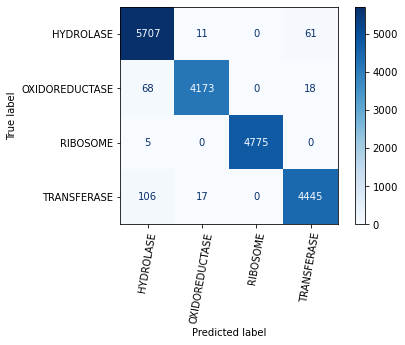

In [328]:
rf = grid.best_estimator_
evaluate_model(X_train,y_train,X_test,y_test,rf)

#### training with smot

Training Score:0.9999855791416705
Testing Score: 0.9842669968018157
precision Score: 0.984319984987845
recall Score: 0.9842669968018157
Cross V Score: [0.97226909 0.96945706 0.97979579]
Cross & Test Diff: -0.010426347933191416
Standard Deviations Away: -2.3888398571653755


,precision,recall,f1-score,support
HYDROLASE,0.972598,0.982696,0.977621,5779.000000
OXIDOREDUCTASE,0.991453,0.980512,0.985952,4259.000000
RIBOSOME,1.000000,0.999163,0.999581,4780.000000
TRANSFERASE,0.976091,0.974168,0.975129,4568.000000
accuracy,0.984267,0.984267,0.984267,0.984267
macro avg,0.985036,0.984135,0.984571,19386.000000
weighted avg,0.984320,0.984267,0.984279,19386.000000


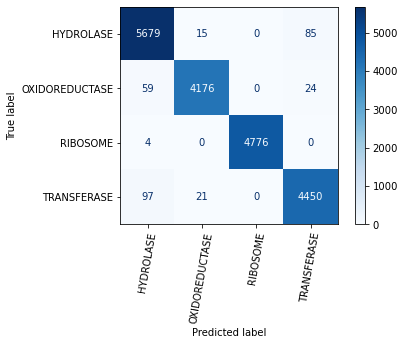

In [381]:
rf = grid.best_estimator_
evaluate_model(X_train_smot,y_train_smote,X_test,y_test,rf)

#### Random Forest Feature Selection

([], <a list of 0 Text major ticklabel objects>)

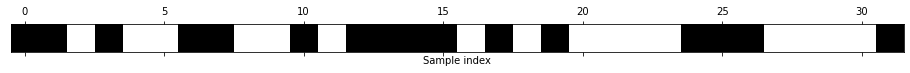

In [329]:
select = SelectFromModel(
    grid.best_estimator_,
    threshold="median")
select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [330]:
X_train_rf = select.transform(X_train)
X_test_rf = select.transform(X_test)

Training Score:0.999982804869661
Testing Score: 0.9811203961621789
precision Score: 0.9812184177021972
recall Score: 0.9811203961621789
Cross V Score: [0.9640978  0.96425071 0.96388961]
Cross & Test Diff: -0.01704102375744221
Standard Deviations Away: -115.14596467207193


,precision,recall,f1-score,support
HYDROLASE,0.966332,0.983388,0.974786,5779.00000
OXIDOREDUCTASE,0.988550,0.972998,0.980712,4259.00000
RIBOSOME,1.000000,0.998745,0.999372,4780.00000
TRANSFERASE,0.973562,0.967382,0.970462,4568.00000
accuracy,0.981120,0.981120,0.981120,0.98112
macro avg,0.982111,0.980628,0.981333,19386.00000
weighted avg,0.981218,0.981120,0.981131,19386.00000


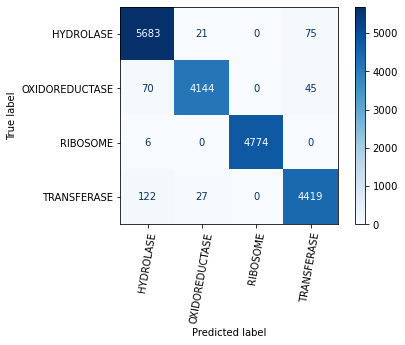

In [331]:
rf = RandomForestClassifier(n_estimators=150,max_features='auto', random_state=42)
evaluate_model(X_train_rf,y_train,X_test_rf,y_test,rf)

In [332]:
xg = xgb.XGBClassifier(learning_rate=0.02, n_estimators=150,objective='multi:softmax',
                    silent=True, nthread=1)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators':[65,150,200,250]
        }

In [333]:
rs =  RandomizedSearchCV(xg, param_distributions=params, n_iter=5
                         , scoring='roc_auc', n_jobs=4, cv=5, verbose=3, random_state=42 )

In [334]:
rs.fit(X_train_smot,y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:07:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=150,...
                                           scale_pos_weight=None, silent=True,
                                           subsample=None, tree_method=None,
                         

In [335]:
rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=True, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

Training Score:0.7762026995846792
Testing Score: 0.7567832456411844
precision Score: 0.7640064482937057
recall Score: 0.7567832456411844
Cross V Score: [0.76335713 0.76231884 0.77377347]
Cross & Test Diff: 0.00969990056215575
Standard Deviations Away: 1.875306262047536


,precision,recall,f1-score,support
0,0.765705,0.624329,0.687828,5779.000000
1,0.638152,0.723409,0.678112,4259.000000
2,0.999791,0.999163,0.999477,4780.000000
3,0.632472,0.701839,0.665352,4568.000000
accuracy,0.756783,0.756783,0.756783,0.756783
macro avg,0.759030,0.762185,0.757692,19386.000000
weighted avg,0.764006,0.756783,0.757240,19386.000000


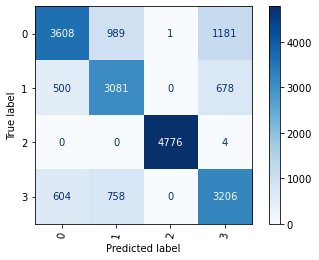

In [336]:
le = LabelEncoder()
le_train = le.fit_transform(y_train_smote)
le_test = le.transform(y_test)
xg = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',eval_metric='logloss',
              learning_rate=0.02, max_delta_step=0, max_depth=4,use_label_encoder=False,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None ,subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
evaluate_model(X_train_smot,le_train,X_test,le_test,xg)

Training Score:0.8354291647438855
Testing Score: 0.812803053750129
precision Score: 0.8176861858912046
recall Score: 0.812803053750129
Cross V Score: [0.81933809 0.82119836 0.82720429]
Cross & Test Diff: 0.009777192904882548
Standard Deviations Away: 2.9127104391094


,precision,recall,f1-score,support
0,0.822538,0.700986,0.756913,5779.000000
1,0.734481,0.791735,0.762034,4259.000000
2,1.000000,0.999582,0.999791,4780.000000
3,0.698350,0.778459,0.736232,4568.000000
accuracy,0.812803,0.812803,0.812803,0.812803
macro avg,0.813842,0.817690,0.813742,19386.000000
weighted avg,0.817686,0.812803,0.813051,19386.000000


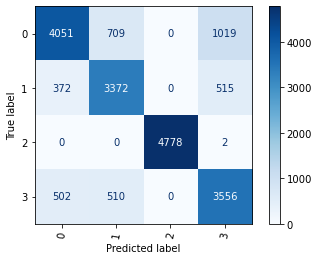

In [337]:
le = LabelEncoder()
le_train = le.fit_transform(y_train_smote)
le_test = le.transform(y_test)
xg = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',eval_metric='logloss',
              learning_rate=0.02, max_delta_step=0, max_depth=4,use_label_encoder=False,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None ,subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
evaluate_model(X_train_smot,le_train,X_test,le_test,xg)